In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, 
                             f1_score, accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_auc_score)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

In [48]:
def feature_selection_chunked(df, feature_names, target='origin', 
                            n_jobs=-1, chunk_size=100):
    """
    Versão otimizada com chunks e barra de progresso
    
    Parâmetros:
    - chunk_size: número de features por chunk (ajuste conforme sua RAM)
    """
    X = df[feature_names].values
    y = df[target].values
    n_features = len(feature_names)
    
    # Divide as features em chunks
    chunks = [feature_names[i:i + chunk_size] 
             for i in range(0, n_features, chunk_size)]
    
    # Função para processar cada chunk
    def process_chunk(chunk_features):
        chunk_idx = [feature_names.index(f) for f in chunk_features]
        return mutual_info_classif(
            X[:, chunk_idx], 
            y,
            n_jobs=1  # Usa 1 núcleo por chunk
        )
    
    # Paraleliza com barra de progresso
    print(f"Processando {len(chunks)} chunks de {chunk_size} features cada...")
    results = []
    with tqdm(total=len(chunks), desc="Processando chunks") as pbar:
        for result in Parallel(n_jobs=n_jobs)(delayed(process_chunk)(chunk) for chunk in chunks):
            results.extend(result)
            pbar.update(1)
    
    # Combina resultados
    mi_df = pd.DataFrame({
        'feature': feature_names,
        'mi_score': results
    }).sort_values('mi_score', ascending=False)
    
    return mi_df

def plot_feature_20importance(features_df):
   
    # Gráfico de barras das features
    plt.figure(figsize=(12, 8))
    plt.barh(features_df['feature'], features_df['mi_score'], color='skyblue')
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.title(f'Top 20 Features por Mutual Information', fontsize=14, pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(features_df, top_n=20, categories=None):
    
    if categories:
        # Análise por categorias
        category_importance = {}
        
        for category, keywords in categories.items():
            cat_features = [f for f in features_df['feature'] if any(k in f for k in keywords)]
            cat_importance = features_df[features_df['feature'].isin(cat_features)]['mi_score'].sum()
            
            category_importance[category] = {
                'importance': cat_importance,
                'count': len(cat_features),
                'features': cat_features,
                'avg_importance': cat_importance / len(cat_features) if cat_features else 0
            }
        
        # Gráfico de pizza por categoria
        plt.figure(figsize=(10, 8))
        sizes = [cat_info['importance'] for cat_info in category_importance.values()]
        labels = [f"{cat}\n({size:.3f})" for cat, size in zip(category_importance.keys(), sizes)]
        colors = [
            '#ff9999',  # vermelho claro
            '#66b3ff',  # azul claro
            '#99ff99',  # verde claro
            '#ffcc99',  # laranja claro
            '#c2c2f0',  # lilás
            '#ffb3e6',  # rosa
            '#c2f0c2',  # verde menta
            '#ff6666',  # vermelho mais forte
            '#66ffcc',  # turquesa
            '#ffd966'   # amarelo
        ]

        
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Distribuição da Importância por Categoria de Features\n(Mutual Information)', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()


In [3]:
df = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/df_mistral_com_features.csv")
feature_columns = [col for col in df.columns if col not in ['text', 'origin']]

In [4]:
# Exemplo de uso:
top_features = feature_selection_chunked(
    df=df,
    feature_names=feature_columns,
    target='origin',
    n_jobs=-1,  # Usa todos os núcleos
    chunk_size=100  # Ajuste conforme sua RAM
)
top_features
top_features.to_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_mistral.csv", index=False)

Processando 4 chunks de 100 features cada...


Processando chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


In [17]:
top_features = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_mistral.csv")
top_features = top_features[~top_features['feature'].isin(['ai', 'intelligence', 'artificial intelligence', 'artificial', 'education', 'students'])]
top20_features = top_features.head(20)

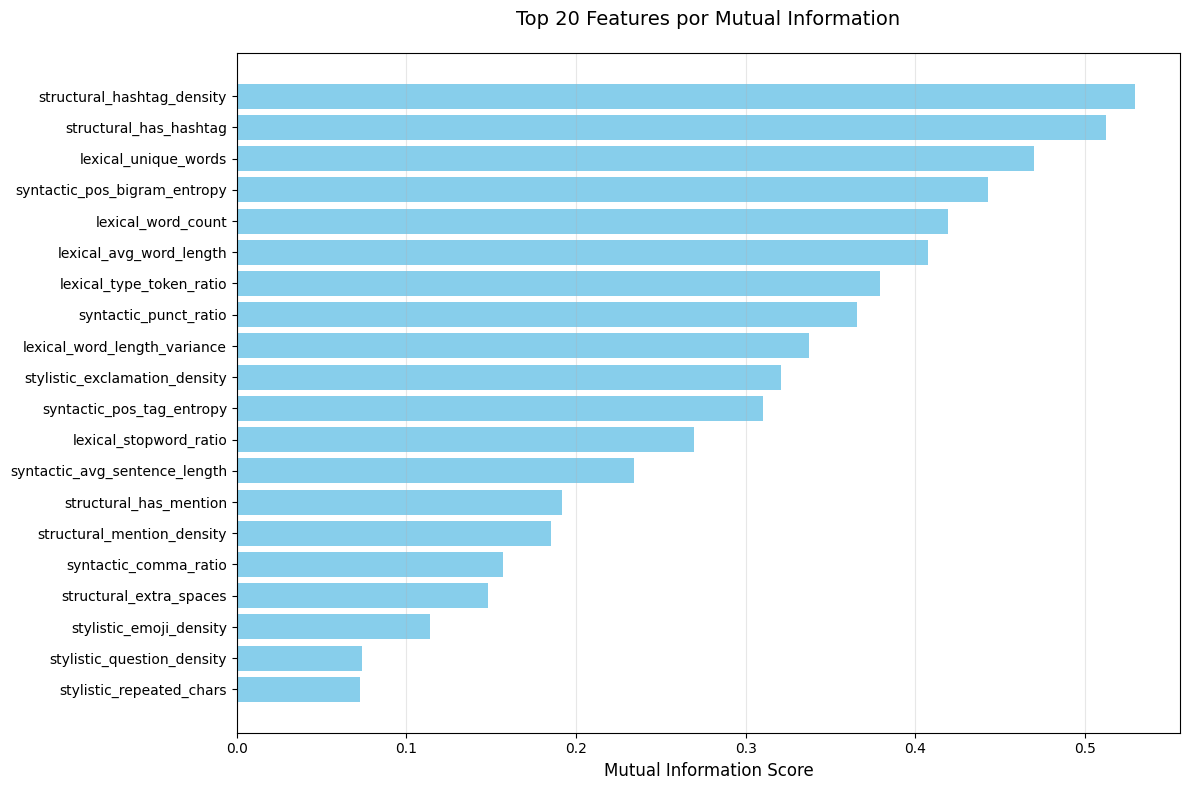

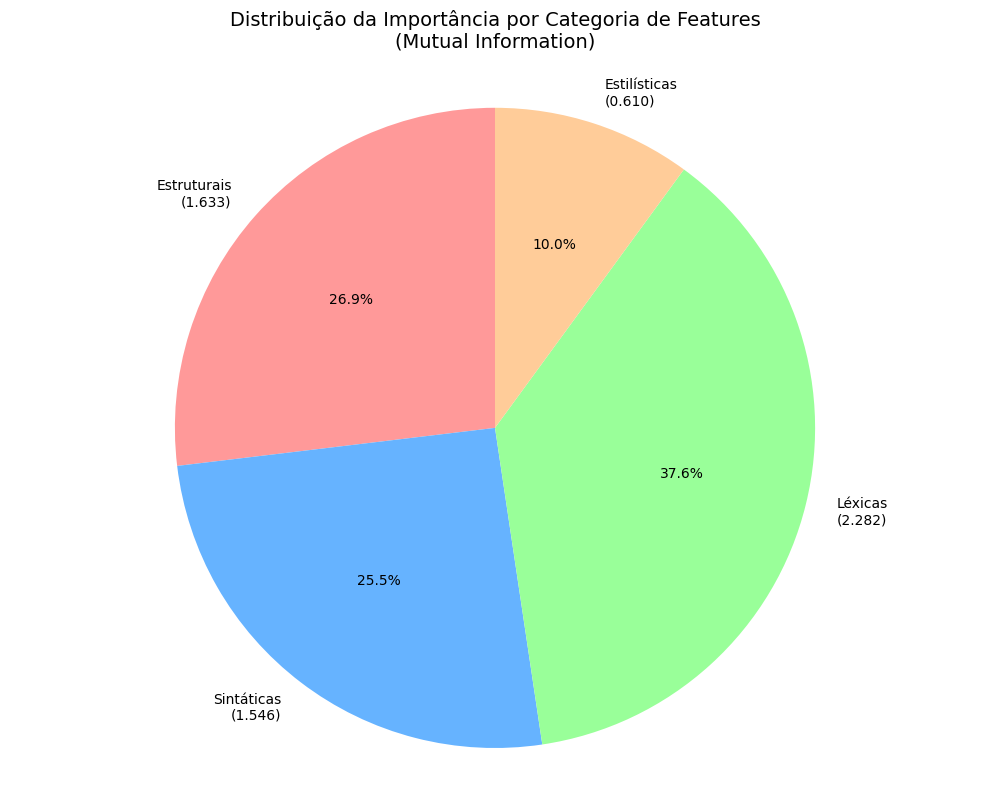

In [18]:
categories = {
    'Estruturais': ['structural'],
    'Sintáticas': ['syntactic'],
    'Léxicas': ['lexical'],
    'Estilísticas': ['stylistic']
}

plot_feature_20importance(top20_features)
plot_feature_importance(top_features, top_n=20, categories=categories)

In [35]:
def random_forest_pipeline(X, y, test_size=0.2, random_state=42, n_estimators=100, cv=5):
    """
    Executa validação cruzada, treino final e plota matriz de confusão
    mostrando 'quantidade / total por classe'.
    Compatível para classificação binária.
    """
    
    # ==================== 1. VALIDAÇÃO CRUZADA ====================
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }
    
    results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA:")
    print("-" * 40)
    for metric in scoring.keys():
        mean_score = np.mean(results['test_' + metric])
        std_score = np.std(results['test_' + metric])
        print(f"{metric:12}: {mean_score:.4f} ± {std_score:.4f}")
    
    # ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
        stratify=y, shuffle=True
    )


    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Métricas finais
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📈 Métricas no conjunto de teste:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    totals = cm.sum(axis=1)[:, np.newaxis]

    # Plot manual para não duplicar textos
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Títulos e eixos
    ax.set_title('Matriz de Confusão - Random Forest\n(Conjunto de Teste)', fontsize=14, pad=20)
    ax.set_xlabel('Predição')
    ax.set_ylabel('Classe Real')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Humano', 'IA'])
    ax.set_yticklabels(['Humano', 'IA'])

    # Adicionar os valores "quantidade/total"
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}/{totals[i,0]}",
                    ha='center', va='center', color='black', fontsize=12)

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    return rf_model, cm, results


In [19]:
X = df[top20_features['feature'].tolist()]
y = df['origin']

/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "/home/tammy.kojima/minic


📊 RESULTADOS DA VALIDAÇÃO CRUZADA:
----------------------------------------
accuracy    : 0.9986 ± 0.0009
precision   : 0.9992 ± 0.0007
recall      : 0.9980 ± 0.0019
f1          : 0.9986 ± 0.0009
roc_auc     : nan ± nan

📈 Métricas no conjunto de teste:
Accuracy : 0.9980
Precision: 0.9990
Recall   : 0.9970
F1-Score : 0.9980
ROC-AUC  : 1.0000


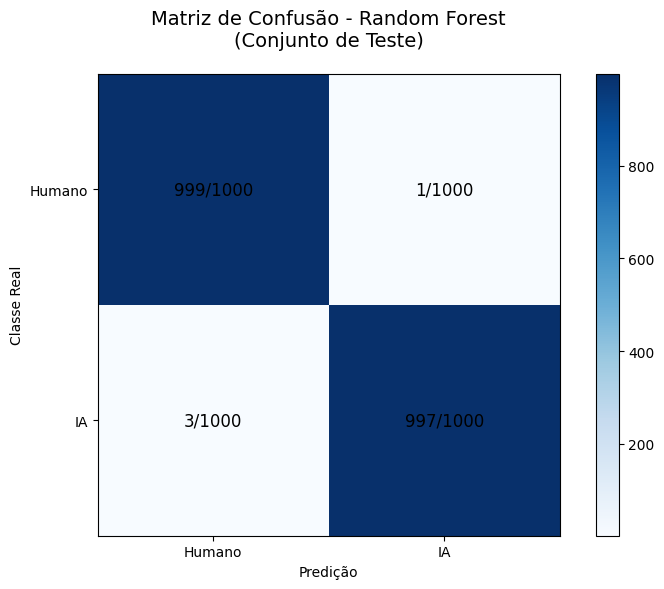

(RandomForestClassifier(n_jobs=-1, random_state=42),
 array([[999,   1],
        [  3, 997]]),
 {'fit_time': array([0.20911694, 0.3013339 , 0.20394897, 0.28850126, 0.26728296]),
  'score_time': array([0.03229952, 0.03449321, 0.03194118, 0.03418517, 0.05312538]),
  'test_accuracy': array([0.9985, 0.999 , 0.997 , 0.999 , 0.9995]),
  'test_precision': array([1.        , 1.        , 0.99899598, 0.99800399, 0.999001  ]),
  'test_recall': array([0.997, 0.998, 0.995, 1.   , 1.   ]),
  'test_f1': array([0.99849775, 0.998999  , 0.99699399, 0.999001  , 0.99950025]),
  'test_roc_auc': array([nan, nan, nan, nan, nan])})

In [36]:
random_forest_pipeline(X, y, test_size=0.2, random_state=42, n_estimators=100)

In [39]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_pipeline(X, y, test_size=0.2, random_state=42, cv=5, max_iter=1000):
    """
    Executa validação cruzada, treino final e plota matriz de confusão
    mostrando 'quantidade / total por classe'.
    Compatível para classificação binária.
    """
    
    # ==================== 1. VALIDAÇÃO CRUZADA ====================
    clf = LogisticRegression(random_state=random_state, max_iter=max_iter, n_jobs=-1)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA (Logistic Regression):")
    print("-" * 40)
    for metric in scoring.keys():
        mean_score = np.mean(results['test_' + metric])
        std_score = np.std(results['test_' + metric])
        print(f"{metric:12}: {mean_score:.4f} ± {std_score:.4f}")

    # ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
        stratify=y, shuffle=True
    )

    log_model = LogisticRegression(random_state=random_state, max_iter=max_iter, n_jobs=-1)
    log_model.fit(X_train, y_train)

    y_pred = log_model.predict(X_test)
    y_pred_proba = log_model.predict_proba(X_test)[:, 1]

    # Métricas finais
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📈 Métricas no conjunto de teste (Logistic Regression):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    totals = cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    ax.set_title('Matriz de Confusão - Regressão Logística\n(Conjunto de Teste)', fontsize=14, pad=20)
    ax.set_xlabel('Predição')
    ax.set_ylabel('Classe Real')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Humano', 'IA'])
    ax.set_yticklabels(['Humano', 'IA'])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}/{totals[i,0]}",
                    ha='center', va='center', color='black', fontsize=12)

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    return log_model, cm, results


/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "/home/tammy.kojima/minic


📊 RESULTADOS DA VALIDAÇÃO CRUZADA (Logistic Regression):
----------------------------------------
accuracy    : 0.9933 ± 0.0014
precision   : 0.9922 ± 0.0010
recall      : 0.9944 ± 0.0022
f1          : 0.9933 ± 0.0014
roc_auc     : nan ± nan

📈 Métricas no conjunto de teste (Logistic Regression):
Accuracy : 0.9940
Precision: 0.9950
Recall   : 0.9930
F1-Score : 0.9940
ROC-AUC  : 0.9986


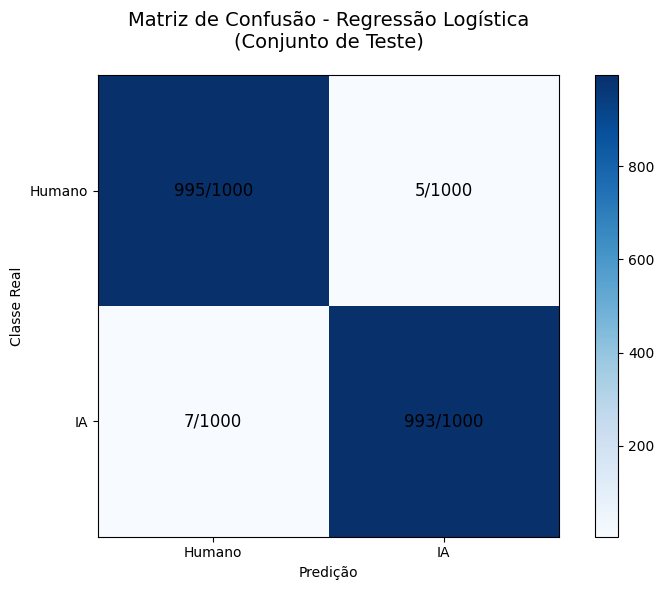

(LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
 array([[995,   5],
        [  7, 993]]),
 {'fit_time': array([0.18153024, 0.12041616, 0.16065574, 0.17171001, 0.16155076]),
  'score_time': array([0.01293302, 0.01461077, 0.00925732, 0.00999427, 0.0083282 ]),
  'test_accuracy': array([0.9915, 0.992 , 0.995 , 0.9945, 0.9935]),
  'test_precision': array([0.99199199, 0.99101796, 0.99401198, 0.9920398 , 0.99202393]),
  'test_recall': array([0.991, 0.993, 0.996, 0.997, 0.995]),
  'test_f1': array([0.99149575, 0.99200799, 0.995005  , 0.99451372, 0.99350974]),
  'test_roc_auc': array([nan, nan, nan, nan, nan])})

In [ ]:
logistic_regression_pipeline(X, y, test_size=0.2, random_state=42, cv=5, max_iter=1000)

In [40]:
from sklearn.svm import SVC

def svc_pipeline(X, y, test_size=0.2, random_state=42, cv=5, kernel="linear", C=1.0):
    """
    Executa validação cruzada, treino final e plota matriz de confusão
    mostrando 'quantidade / total por classe'.
    Compatível para classificação binária.
    """
    
    # ==================== 1. VALIDAÇÃO CRUZADA ====================
    clf = SVC(kernel=kernel, C=C, probability=True, random_state=random_state)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA (SVC):")
    print("-" * 40)
    for metric in scoring.keys():
        mean_score = np.mean(results['test_' + metric])
        std_score = np.std(results['test_' + metric])
        print(f"{metric:12}: {mean_score:.4f} ± {std_score:.4f}")

    # ==================== 2. TREINAMENTO E MATRIZ DE CONFUSÃO ====================
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
        stratify=y, shuffle=True
    )

    svc_model = SVC(kernel=kernel, C=C, probability=True, random_state=random_state)
    svc_model.fit(X_train, y_train)

    y_pred = svc_model.predict(X_test)
    y_pred_proba = svc_model.predict_proba(X_test)[:, 1]

    # Métricas finais
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📈 Métricas no conjunto de teste (SVC):")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    totals = cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    ax.set_title('Matriz de Confusão - SVC\n(Conjunto de Teste)', fontsize=14, pad=20)
    ax.set_xlabel('Predição')
    ax.set_ylabel('Classe Real')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Humano', 'IA'])
    ax.set_yticklabels(['Humano', 'IA'])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}/{totals[i,0]}",
                    ha='center', va='center', color='black', fontsize=12)

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    return svc_model, cm, results


/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "/home/tammy.kojima/minic


📊 RESULTADOS DA VALIDAÇÃO CRUZADA (SVC):
----------------------------------------
accuracy    : 0.9947 ± 0.0018
precision   : 0.9938 ± 0.0029
recall      : 0.9956 ± 0.0014
f1          : 0.9947 ± 0.0018
roc_auc     : nan ± nan

📈 Métricas no conjunto de teste (SVC):
Accuracy : 0.9960
Precision: 0.9960
Recall   : 0.9960
F1-Score : 0.9960
ROC-AUC  : 0.9989


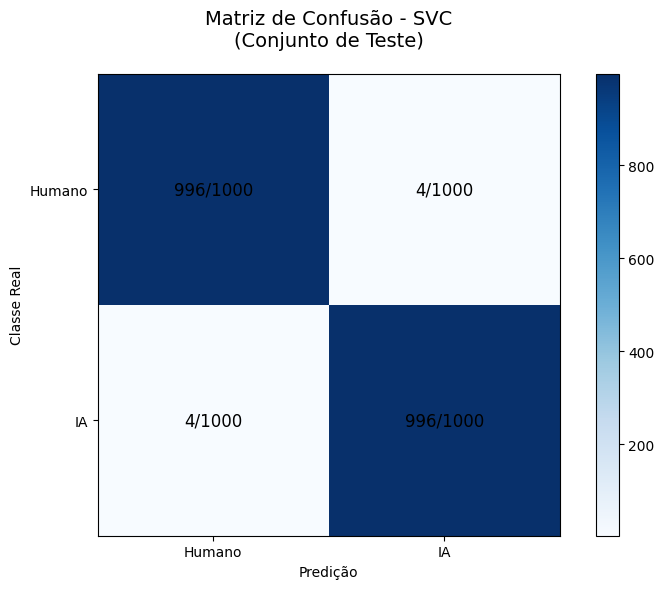

(SVC(kernel='linear', probability=True, random_state=42),
 array([[996,   4],
        [  4, 996]]),
 {'fit_time': array([1.05816698, 0.81013322, 1.06405139, 1.012676  , 1.12995481]),
  'score_time': array([0.01405954, 0.01420426, 0.01554155, 0.01481056, 0.01310277]),
  'test_accuracy': array([0.996 , 0.9925, 0.996 , 0.9925, 0.9965]),
  'test_precision': array([0.99500998, 0.99200799, 0.996     , 0.98907646, 0.996997  ]),
  'test_recall': array([0.997, 0.993, 0.996, 0.996, 0.996]),
  'test_f1': array([0.996004  , 0.99250375, 0.996     , 0.99252616, 0.99649825]),
  'test_roc_auc': array([nan, nan, nan, nan, nan])})

In [42]:
svc_pipeline(X, y, test_size=0.2, random_state=42, cv=5, kernel="linear", C=1.0)

In [43]:
df = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/df_mistral_com_features2.csv")
feature_columns = [col for col in df.columns if col not in ['text', 'origin']]

In [44]:
# Exemplo de uso:
top_features = feature_selection_chunked(
    df=df,
    feature_names=feature_columns,
    target='origin',
    n_jobs=-1,  # Usa todos os núcleos
    chunk_size=100  # Ajuste conforme sua RAM
)
top_features
top_features.to_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_mistral2.csv", index=False)

Processando 4 chunks de 100 features cada...


Processando chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


In [46]:
top_features = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_mistral2.csv")
top_features = top_features[~top_features['feature'].isin(['ai', 'intelligence', 'artificial intelligence', 'artificial', 'education', 'students'])]
top20_features = top_features.head(20)

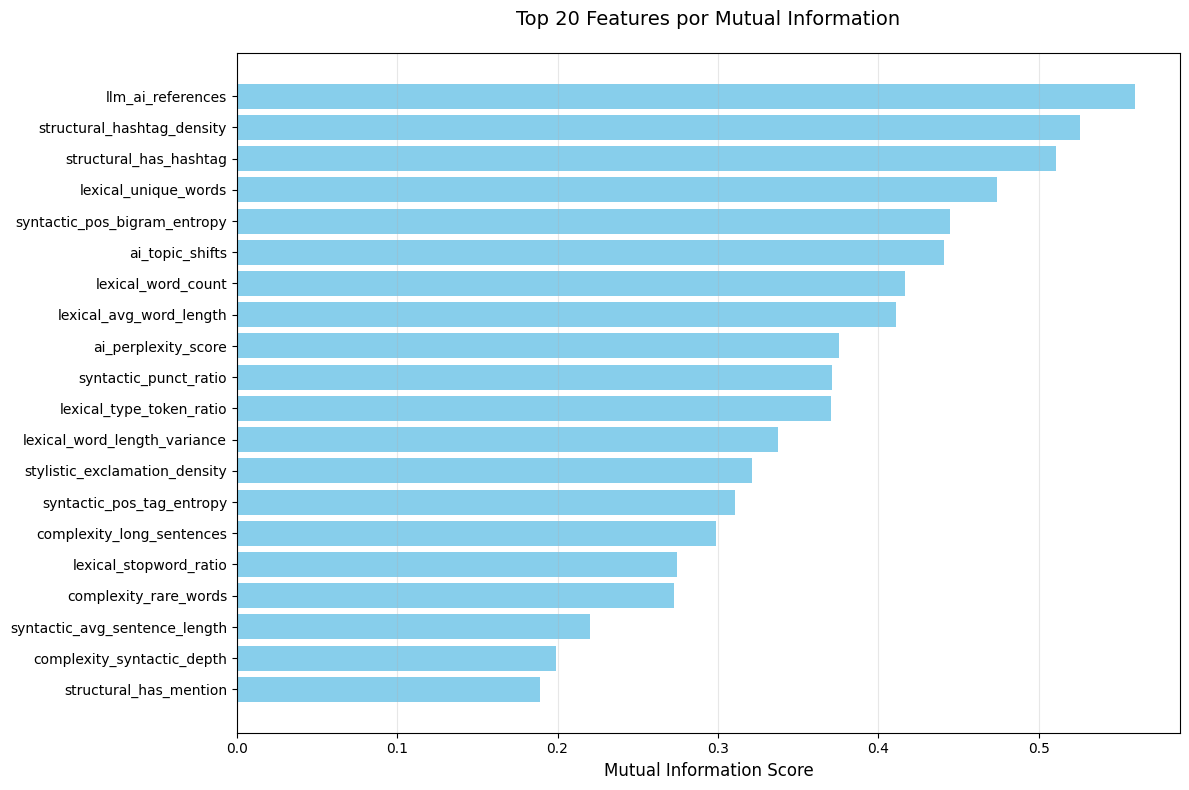

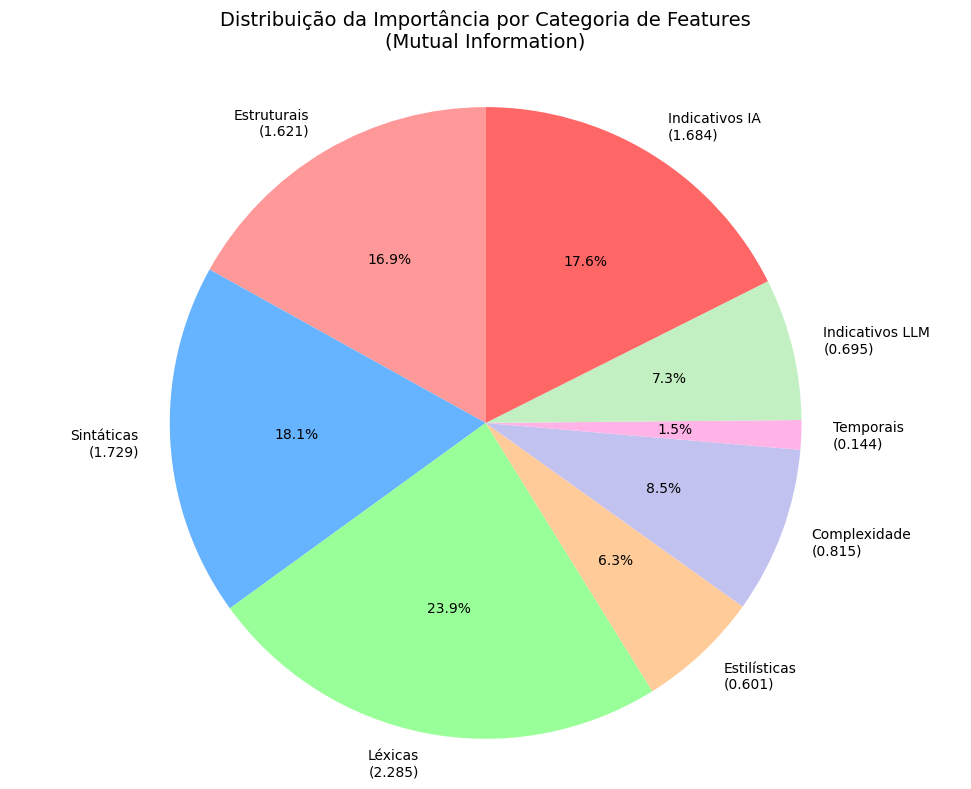

In [49]:
categories = {
    'Estruturais': ['structural'],
    'Sintáticas': ['syntactic'],
    'Léxicas': ['lexical'],
    'Estilísticas': ['stylistic'],
    'Complexidade': ['complexity'],
    'Temporais': ['temporal'],
    'Indicativos LLM': ['llm', 'mistral'],
    'Indicativos IA': ['ai']
}

plot_feature_20importance(top20_features)
plot_feature_importance(top_features, top_n=20, categories=categories)

In [50]:
X = df[top20_features['feature'].tolist()]
y = df['origin']

/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "/home/tammy.kojima/minic


📊 RESULTADOS DA VALIDAÇÃO CRUZADA:
----------------------------------------
accuracy    : 0.9983 ± 0.0009
precision   : 0.9984 ± 0.0012
recall      : 0.9982 ± 0.0017
f1          : 0.9983 ± 0.0009
roc_auc     : nan ± nan

📈 Métricas no conjunto de teste:
Accuracy : 0.9980
Precision: 0.9980
Recall   : 0.9980
F1-Score : 0.9980
ROC-AUC  : 0.9994


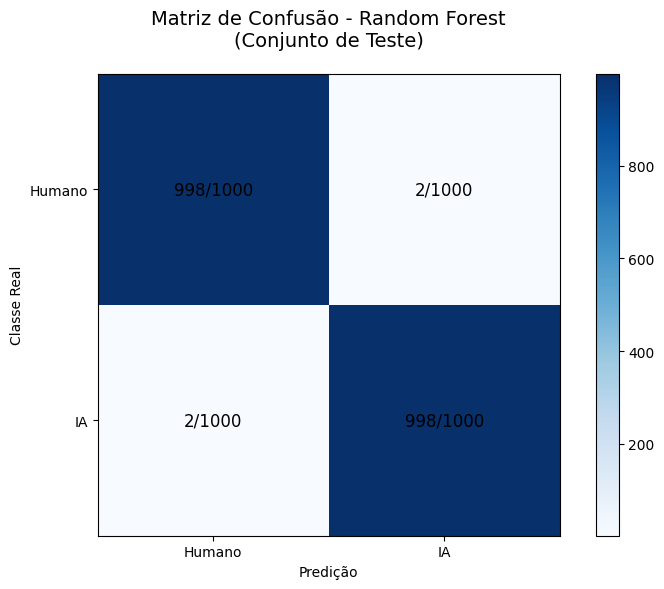

(RandomForestClassifier(n_jobs=-1, random_state=42),
 array([[998,   2],
        [  2, 998]]),
 {'fit_time': array([0.28896189, 0.29162884, 0.30292034, 0.20988941, 0.20916581]),
  'score_time': array([0.0483849 , 0.04859734, 0.03368306, 0.03330374, 0.03324008]),
  'test_accuracy': array([0.9985, 0.997 , 0.999 , 0.9995, 0.9975]),
  'test_precision': array([0.998999  , 0.99899598, 0.999     , 0.999001  , 0.99601196]),
  'test_recall': array([0.998, 0.995, 0.999, 1.   , 0.999]),
  'test_f1': array([0.99849925, 0.99699399, 0.999     , 0.99950025, 0.99750374]),
  'test_roc_auc': array([nan, nan, nan, nan, nan])})

In [51]:
random_forest_pipeline(X, y, test_size=0.2, random_state=42, n_estimators=100)

/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "/home/tammy.kojima/minic


📊 RESULTADOS DA VALIDAÇÃO CRUZADA (Logistic Regression):
----------------------------------------
accuracy    : 0.9927 ± 0.0012
precision   : 0.9910 ± 0.0018
recall      : 0.9944 ± 0.0021
f1          : 0.9927 ± 0.0012
roc_auc     : nan ± nan

📈 Métricas no conjunto de teste (Logistic Regression):
Accuracy : 0.9945
Precision: 0.9940
Recall   : 0.9950
F1-Score : 0.9945
ROC-AUC  : 0.9987


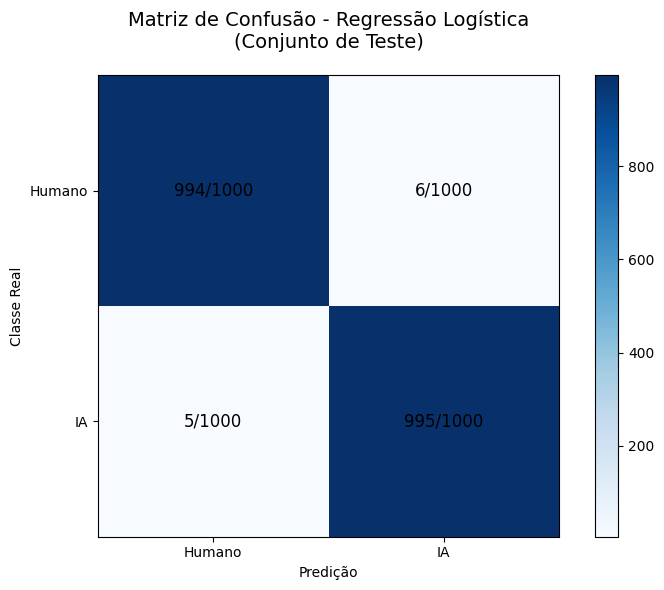

(LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
 array([[994,   6],
        [  5, 995]]),
 {'fit_time': array([0.16220975, 0.15217662, 0.14967179, 0.15218258, 0.1401031 ]),
  'score_time': array([0.01425028, 0.00939918, 0.00972128, 0.0094614 , 0.00907612]),
  'test_accuracy': array([0.992 , 0.9915, 0.995 , 0.9925, 0.9925]),
  'test_precision': array([0.99298597, 0.98905473, 0.99302789, 0.98907646, 0.99102692]),
  'test_recall': array([0.991, 0.994, 0.997, 0.996, 0.994]),
  'test_f1': array([0.99199199, 0.9915212 , 0.99500998, 0.99252616, 0.99251123]),
  'test_roc_auc': array([nan, nan, nan, nan, nan])})

In [52]:
logistic_regression_pipeline(X, y, test_size=0.2, random_state=42, cv=5, max_iter=1000)

/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/inspect.py", line 3045, in bind
    return self._bind(args, kwargs)
  File "/home/tammy.kojima/minic


📊 RESULTADOS DA VALIDAÇÃO CRUZADA (SVC):
----------------------------------------
accuracy    : 0.9944 ± 0.0017
precision   : 0.9940 ± 0.0023
recall      : 0.9948 ± 0.0023
f1          : 0.9944 ± 0.0017
roc_auc     : nan ± nan

📈 Métricas no conjunto de teste (SVC):
Accuracy : 0.9955
Precision: 0.9970
Recall   : 0.9940
F1-Score : 0.9955
ROC-AUC  : 0.9987


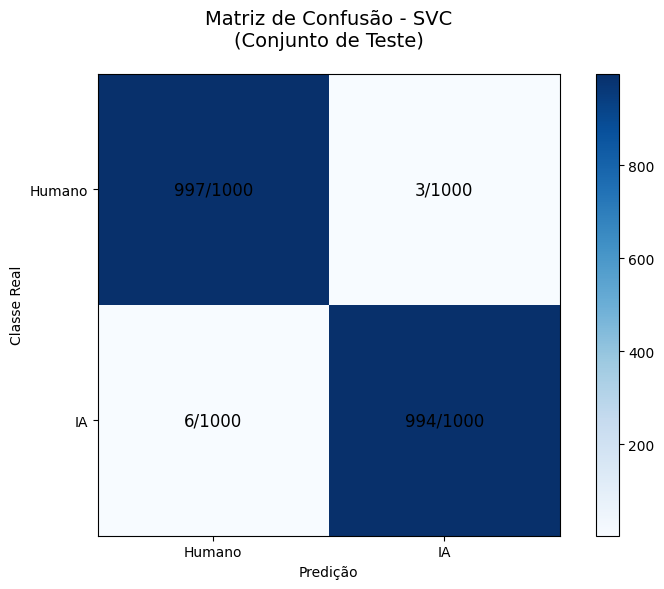

(SVC(kernel='linear', probability=True, random_state=42),
 array([[997,   3],
        [  6, 994]]),
 {'fit_time': array([1.01973295, 0.97967815, 1.41841221, 1.26527214, 1.63053131]),
  'score_time': array([0.01745367, 0.01309991, 0.01486444, 0.01460767, 0.01370525]),
  'test_accuracy': array([0.993, 0.993, 0.997, 0.993, 0.996]),
  'test_precision': array([0.99398798, 0.99398798, 0.997     , 0.99005964, 0.99500998]),
  'test_recall': array([0.992, 0.992, 0.997, 0.996, 0.997]),
  'test_f1': array([0.99299299, 0.99299299, 0.997     , 0.99302094, 0.996004  ]),
  'test_roc_auc': array([nan, nan, nan, nan, nan])})

In [53]:
svc_pipeline(X, y, test_size=0.2, random_state=42, cv=5, kernel="linear", C=1.0)

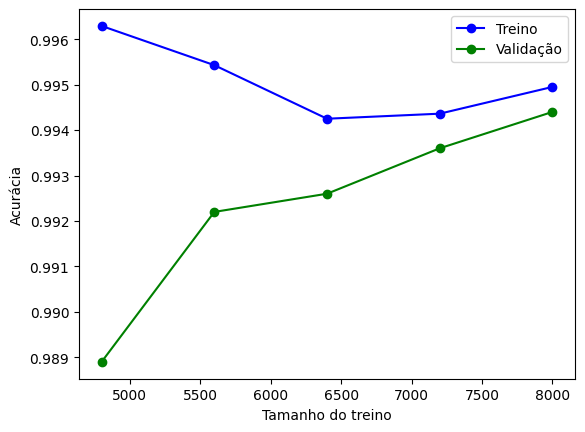

In [55]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

model = SVC(
    kernel="linear",   # kernel linear
    C=1.0,             # regularização
    probability=True,  # necessário se quiser calcular ROC-AUC
    random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Treino')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validação')
plt.xlabel('Tamanho do treino')
plt.ylabel('Acurácia')
plt.legend()
plt.show()
